# Pneumonia X-ray 

In [1]:
# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
import os

In [3]:
import itertools

import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from plotly.offline import iplot

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers
from keras.callbacks import EarlyStopping, LearningRateScheduler
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.efficientnet import preprocess_input

print ('modules loaded')

modules loaded


In [4]:
train_data_path = 'dataset/train'
test_data_path = 'dataset/test'
valid_data_path = 'dataset/val'

In [5]:
labels = os.listdir(train_data_path)
labels

['normal', 'pneumonia']

In [6]:
data_path = 'dataset/data'

In [7]:


if not os.path.exists(data_path):
    os.mkdir(data_path)
    print(f"{data_path} folder Created Succesfulley!")
else:
    print(f"{data_path} folder already exist")

dataset/data folder already exist


In [8]:
normal_data_path = 'dataset/data/normal'
pneumonia_data_path = 'dataset/data/pneumonia'

if not os.path.exists(normal_data_path):
    os.mkdir(normal_data_path)
    print(f"{normal_data_path} Folder Created Succesfulley!")
else:
    print(f"{normal_data_path} Folder already exist")
    
if not os.path.exists(pneumonia_data_path):
    os.mkdir(pneumonia_data_path)
    print(f"{pneumonia_data_path} Folder Created Succesfulley!")
else:
    print(f"{pneumonia_data_path} Folder already exist")

dataset/data/normal Folder already exist
dataset/data/pneumonia Folder already exist


In [9]:
def move_data(d_path, saved_path):
    for i in labels:
        images = os.listdir(d_path + '/' + i)
        for j in images:
            path = d_path +'/' + i
            img = cv2.imread(path + '/' + j)
            s_path = saved_path + '/' + i + '/' + j
            cv2.imwrite(s_path, img)

In [10]:
move_data(train_data_path, data_path)

In [11]:
norm_path = len(os.listdir(data_path + '/' + labels[1]))
penu_path = len(os.listdir(data_path + '/' + labels[0]))
print(norm_path+penu_path)

5856


In [12]:
move_data(test_data_path, data_path)

In [13]:
norm_path = len(os.listdir(data_path + '/' + labels[0]))
oscc_path = len(os.listdir(data_path + '/' + labels[1]))
print(norm_path+oscc_path)

5856


In [14]:
move_data(valid_data_path, data_path)

In [15]:
norm_path = len(os.listdir(data_path + '/' + labels[0]))
oscc_path = len(os.listdir(data_path + '/' + labels[1]))
print(norm_path+oscc_path)

5856


### EDA

In [16]:
data_dir = 'dataset/data'
ds_name = 'Pneumonia Chest x-ray'

In [17]:
# Generate data paths with labels

def generate_data_paths(data_dir):
    
    filepaths = []
    labels = []

    folds = os.listdir(data_dir)
    for fold in folds:
        foldpath = os.path.join(data_dir, fold)
        filelist = os.listdir(foldpath)
        for file in filelist:
            fpath = os.path.join(foldpath, file)
            filepaths.append(fpath)
            labels.append(fold)
            
    return filepaths, labels


filepaths, labels = generate_data_paths(data_dir)

In [18]:
filepaths[0]

'dataset/data\\normal\\IM-0001-0001.jpeg'

In [19]:
len(filepaths)

5856

In [20]:
labels[0]

'normal'

In [21]:
len(labels)

5856

In [22]:
def create_df(filepaths, labels):

    Fseries = pd.Series(filepaths, name= 'filepaths')
    Lseries = pd.Series(labels, name='labels')
    df = pd.concat([Fseries, Lseries], axis= 1)
    return df

df = create_df(filepaths, labels)

In [23]:
df.head()

,filepaths,labels
0,dataset/data\normal\IM-0001-0001.jpeg,normal
1,dataset/data\normal\IM-0003-0001.jpeg,normal
2,dataset/data\normal\IM-0005-0001.jpeg,normal
3,dataset/data\normal\IM-0006-0001.jpeg,normal
4,dataset/data\normal\IM-0007-0001.jpeg,normal


In [24]:
def num_of_examples(df, name='df'):
    print(f"The {name} dataset has {df.shape[0]} images.")
    
num_of_examples(df, ds_name)

The Pneumonia Chest x-ray dataset has 5856 images.


In [25]:
def num_of_classes(df, name='df'):
    print(f"The {name} dataset has {len(df['labels'].unique())} classes")
    
num_of_classes(df, ds_name)

The Pneumonia Chest x-ray dataset has 2 classes


In [26]:
def classes_count(df, name='df'):
    
    print(f"The {name} dataset has: ")
    print("="*70)
    print()
    for name in df['labels'].unique():
        num_class = len(df['labels'][df['labels'] == name])
        print(f"Class '{name}' has {num_class} images")
        print('-'*70)
        
classes_count(df, ds_name)

The Pneumonia Chest x-ray dataset has: 

Class 'normal' has 1583 images
----------------------------------------------------------------------
Class 'pneumonia' has 4273 images
----------------------------------------------------------------------


In [27]:
def cat_summary_with_graph(dataframe, col_name):
    
    fig = make_subplots(rows=1, cols=2,
                        subplot_titles=('Countplot', 'Percentages'),
                        specs=[[{"type": "xy"}, {'type': 'domain'}]])

    fig.add_trace(go.Bar(y=dataframe[col_name].value_counts().values.tolist(),
                         x=[str(i) for i in dataframe[col_name].value_counts().index],
                         text=dataframe[col_name].value_counts().values.tolist(),
                         textfont=dict(size=15),
                         name=col_name,
                         textposition='auto',
                         showlegend=False,
                         marker=dict(color=colors,
                                     line=dict(color='#DBE6EC',
                                               width=1))),
                  row=1, col=1)

    fig.add_trace(go.Pie(labels=dataframe[col_name].value_counts().keys(),
                         values=dataframe[col_name].value_counts().values,
                         textfont=dict(size=20),
                         textposition='auto',
                         showlegend=False,
                         name=col_name,
                         marker=dict(colors=colors)),
                  row=1, col=2)

    fig.update_layout(title={'text': col_name,
                             'y': 0.9,
                             'x': 0.5,
                             'xanchor': 'center',
                             'yanchor': 'top'},
                      template='plotly_white')

    iplot(fig)
    
    
colors = ['#494BD3', '#E28AE2', '#F1F481', '#79DB80', '#DF5F5F',
              '#69DADE', '#C2E37D', '#E26580', '#D39F49', '#B96FE3']

cat_summary_with_graph(df,'labels')

In [28]:
# train dataframe
train_df, dummy_df = train_test_split(df,  train_size= 0.8, shuffle= True, random_state= 123)

# valid and test dataframe
valid_df, test_df = train_test_split(dummy_df,  train_size= 0.6, shuffle= True, random_state= 123)

In [29]:
num_of_classes(train_df, "Training "+ds_name)
num_of_classes(valid_df, "Validation "+ds_name)
num_of_classes(test_df, "Testing "+ds_name)

The Training Pneumonia Chest x-ray dataset has 2 classes
The Validation Pneumonia Chest x-ray dataset has 2 classes
The Testing Pneumonia Chest x-ray dataset has 2 classes


In [30]:
classes_count(train_df, 'Training '+ds_name)

The Training Pneumonia Chest x-ray dataset has: 

Class 'normal' has 1259 images
----------------------------------------------------------------------
Class 'pneumonia' has 3425 images
----------------------------------------------------------------------


In [31]:
classes_count(valid_df, 'Validation '+ds_name)

The Validation Pneumonia Chest x-ray dataset has: 

Class 'normal' has 194 images
----------------------------------------------------------------------
Class 'pneumonia' has 509 images
----------------------------------------------------------------------


In [32]:
classes_count(test_df, 'Testing '+ds_name)

The Testing Pneumonia Chest x-ray dataset has: 

Class 'normal' has 130 images
----------------------------------------------------------------------
Class 'pneumonia' has 339 images
----------------------------------------------------------------------


In [33]:
# crobed image size
batch_size = 16
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

# Recommended : use custom function for test data batch size, else we can use normal batch size.
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

# This function which will be used in image data generator for data augmentation, it just take the image and return it again.
def scalar(img):
    return img

tr_gen = ImageDataGenerator(preprocessing_function= scalar,
                           rotation_range=40,
                           width_shift_range=0.2,
                           height_shift_range=0.2,
                           brightness_range=[0.4,0.6],
                           zoom_range=0.3,
                           horizontal_flip=True,
                           vertical_flip=True)
ts_gen = ImageDataGenerator(preprocessing_function= scalar,
                           rotation_range=40,
                           width_shift_range=0.2,
                           height_shift_range=0.2,
                           brightness_range=[0.4,0.6],
                           zoom_range=0.3,
                           horizontal_flip=True,
                           vertical_flip=True)

train_gen = tr_gen.flow_from_dataframe(train_df, 
                                       x_col= 'filepaths', 
                                       y_col= 'labels', 
                                       target_size= img_size, 
                                       class_mode= 'categorical',
                                       color_mode= 'rgb', 
                                       shuffle= True, 
                                       batch_size= batch_size)

valid_gen = ts_gen.flow_from_dataframe(valid_df, 
                                       x_col= 'filepaths', 
                                       y_col= 'labels', 
                                       target_size= img_size, 
                                       class_mode= 'categorical',
                                       color_mode= 'rgb', 
                                       shuffle= True, 
                                       batch_size= batch_size)
# Note: we will use custom test_batch_size, and make shuffle= false
test_gen = ts_gen.flow_from_dataframe(test_df, 
                                      x_col= 'filepaths', 
                                      y_col= 'labels', 
                                      target_size= img_size, 
                                      class_mode= 'categorical',
                                      color_mode= 'rgb', 
                                      shuffle= False, 
                                      batch_size= test_batch_size)

Found 4684 validated image filenames belonging to 2 classes.
Found 703 validated image filenames belonging to 2 classes.
Found 469 validated image filenames belonging to 2 classes.


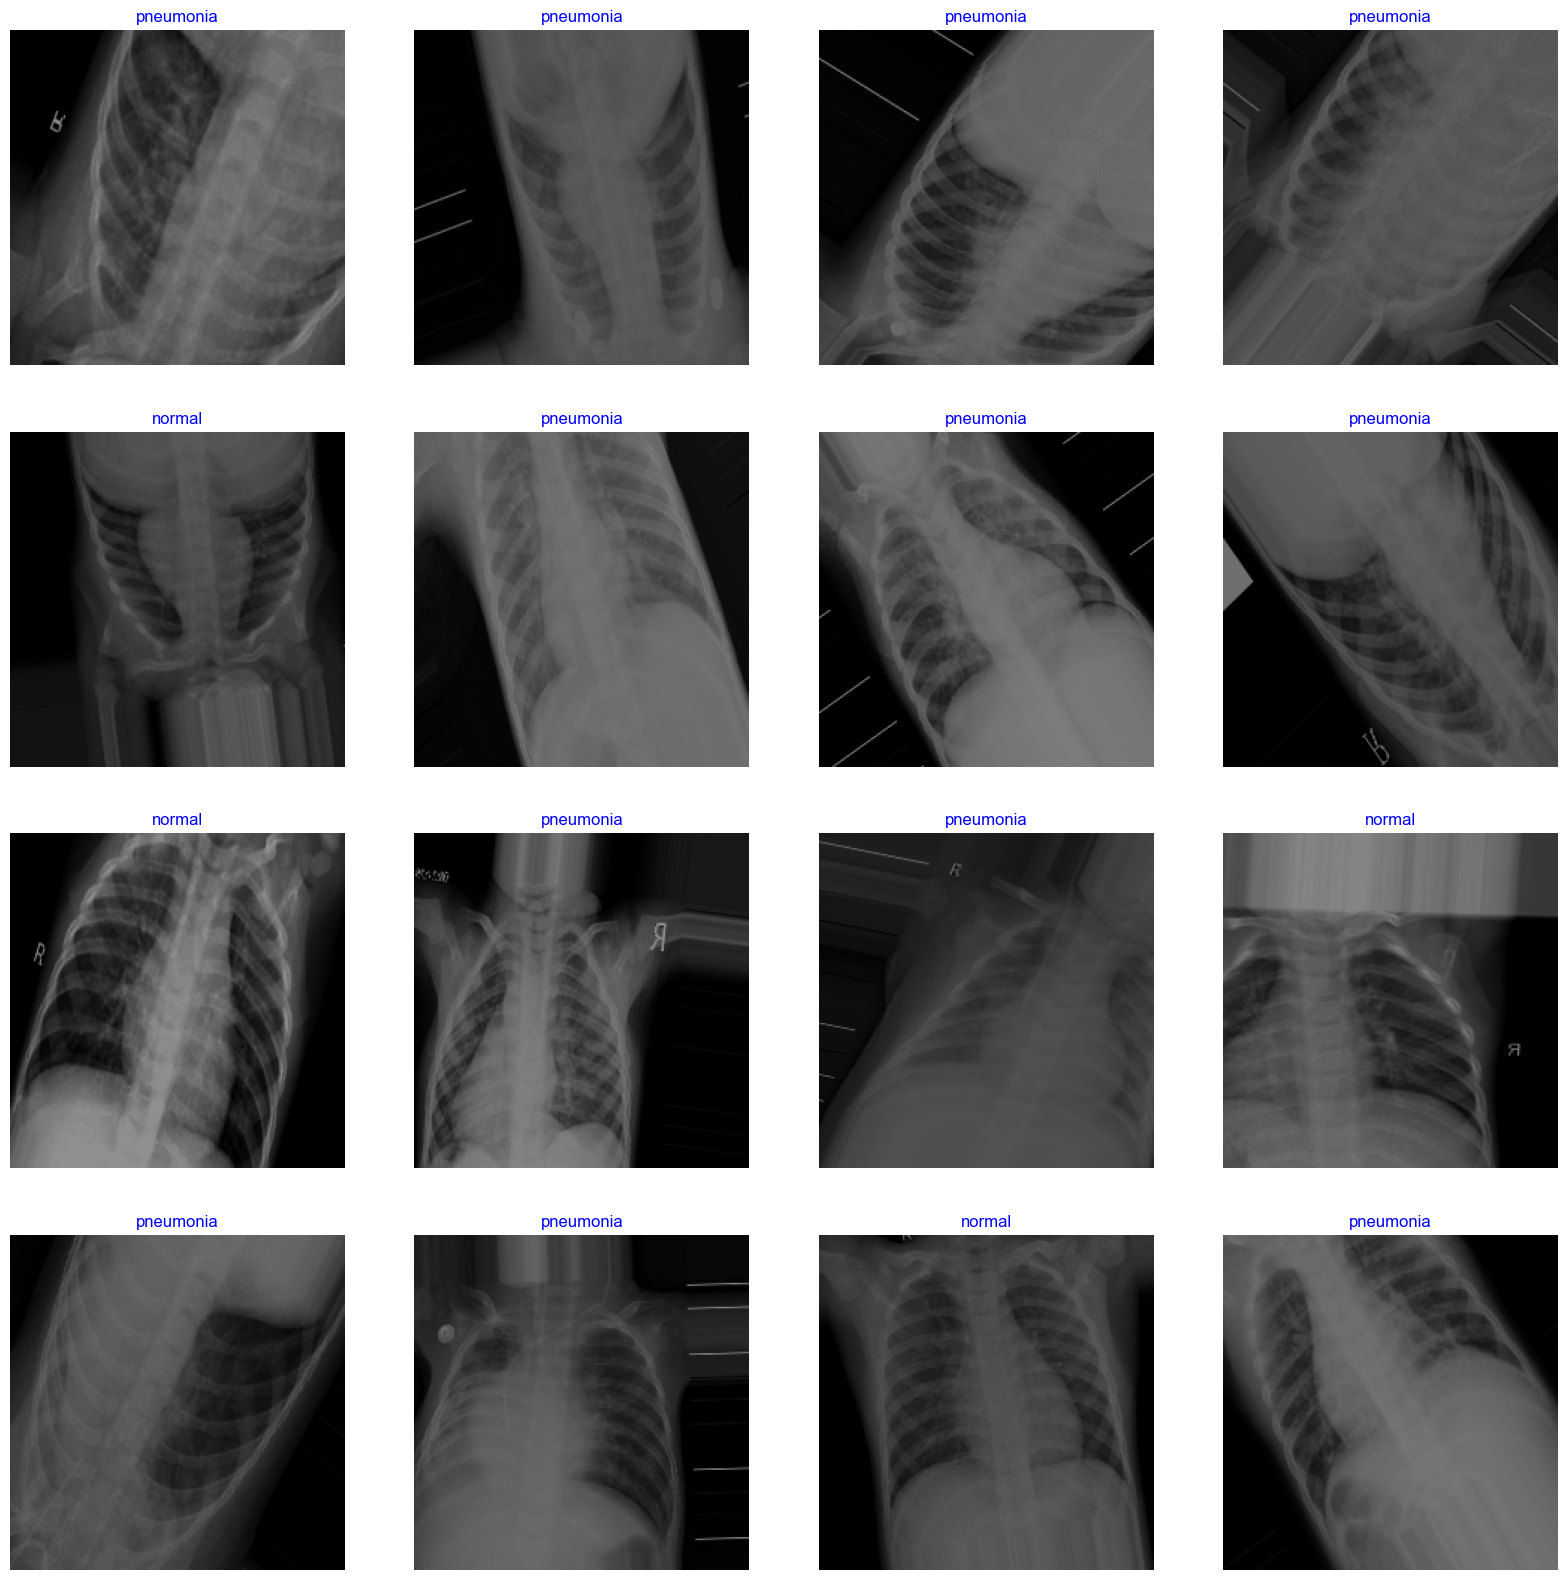

In [34]:
g_dict = train_gen.class_indices      # defines dictionary {'class': index}
classes = list(g_dict.keys())       # defines list of dictionary's kays (classes), classes names : string
images, labels = next(train_gen)      # get a batch size samples from the generator

plt.figure(figsize= (20, 20))

for i in range(16):
    plt.subplot(4, 4, i + 1)
    image = images[i] / 255       # scales data to range (0 - 255)
    plt.imshow(image)
    index = np.argmax(labels[i])  # get image index
    class_name = classes[index]   # get class of image
    plt.title(class_name, color= 'blue', fontsize= 12)
    plt.axis('off')
    
plt.show()

In [35]:
img_size[0]

224

In [36]:
img_size[1]

224

### Model

In [37]:
# Create Model Structure
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys())) # to define number of classes in dense layer

# create pre-trained model (you can built on pretrained model such as :  efficientnet, VGG , Resnet )
# we will use resnet50 from ResNet family.
base_model = tf.keras.applications.resnet50.ResNet50(include_top= False, 
                                                     weights= "imagenet", 
                                                     input_shape= img_shape, 
                                                     pooling= 'max')
base_model.trainable = False

model = Sequential([
    base_model,
    BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
    Dense(256, kernel_regularizer= regularizers.l2(l= 0.016), activity_regularizer= regularizers.l1(0.006),
                bias_regularizer= regularizers.l1(0.006), activation= 'relu'),
    Dropout(rate= 0.3, seed= 123),
    Dense(class_count, activation= 'sigmoid')
])

model.compile(Adamax(learning_rate= 0.001), loss= 'binary_crossentropy', metrics= ['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 batch_normalization (Batch  (None, 2048)              8192      
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 2)                 514       
                                                                 
Total params: 24120962 (92.01 MB)
Trainable params: 529154 (2.02 MB)
Non-trainable params: 23591808 (90.00 MB)
___________

In [38]:
early_stopping = EarlyStopping(monitor='val_loss', 
                               patience=5, 
                               restore_best_weights=True,
                               mode='min',
                              )

def step_decay(epoch):
    
     initial_lrate = 0.1
     drop = 0.5
     epochs_drop = 10.0
     lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
     return lrate

lr_scheduler = LearningRateScheduler(step_decay)

In [40]:
batch_size = 40   # set batch size for training
epochs = 20   # number of all epochs in training

history = model.fit(x=train_gen,
                    epochs= epochs,
                    verbose= 1,
                    validation_data= valid_gen, 
                    validation_steps= None,
                    shuffle= False,
                    batch_size= batch_size)

Epoch 1/20
293/293 [==============================] - 285s 975ms/step - loss: 0.3775 - accuracy: 0.9272 - val_loss: 0.3297 - val_accuracy: 0.9459
Epoch 2/20
293/293 [==============================] - 300s 1s/step - loss: 0.3542 - accuracy: 0.9276 - val_loss: 0.3170 - val_accuracy: 0.9431
Epoch 3/20
293/293 [==============================] - 1507s 5s/step - loss: 0.3447 - accuracy: 0.9261 - val_loss: 0.3103 - val_accuracy: 0.9388
Epoch 4/20
293/293 [==============================] - 163s 557ms/step - loss: 0.3282 - accuracy: 0.9302 - val_loss: 0.2942 - val_accuracy: 0.9445
Epoch 5/20
293/293 [==============================] - 163s 556ms/step - loss: 0.3210 - accuracy: 0.9287 - val_loss: 0.2889 - val_accuracy: 0.9403
Epoch 6/20
293/293 [==============================] - 168s 574ms/step - loss: 0.3135 - accuracy: 0.9291 - val_loss: 0.2825 - val_accuracy: 0.9388
Epoch 7/20
293/293 [==============================] - 169s 576ms/step - loss: 0.3059 - accuracy: 0.9298 - val_loss: 0.2758 - val_

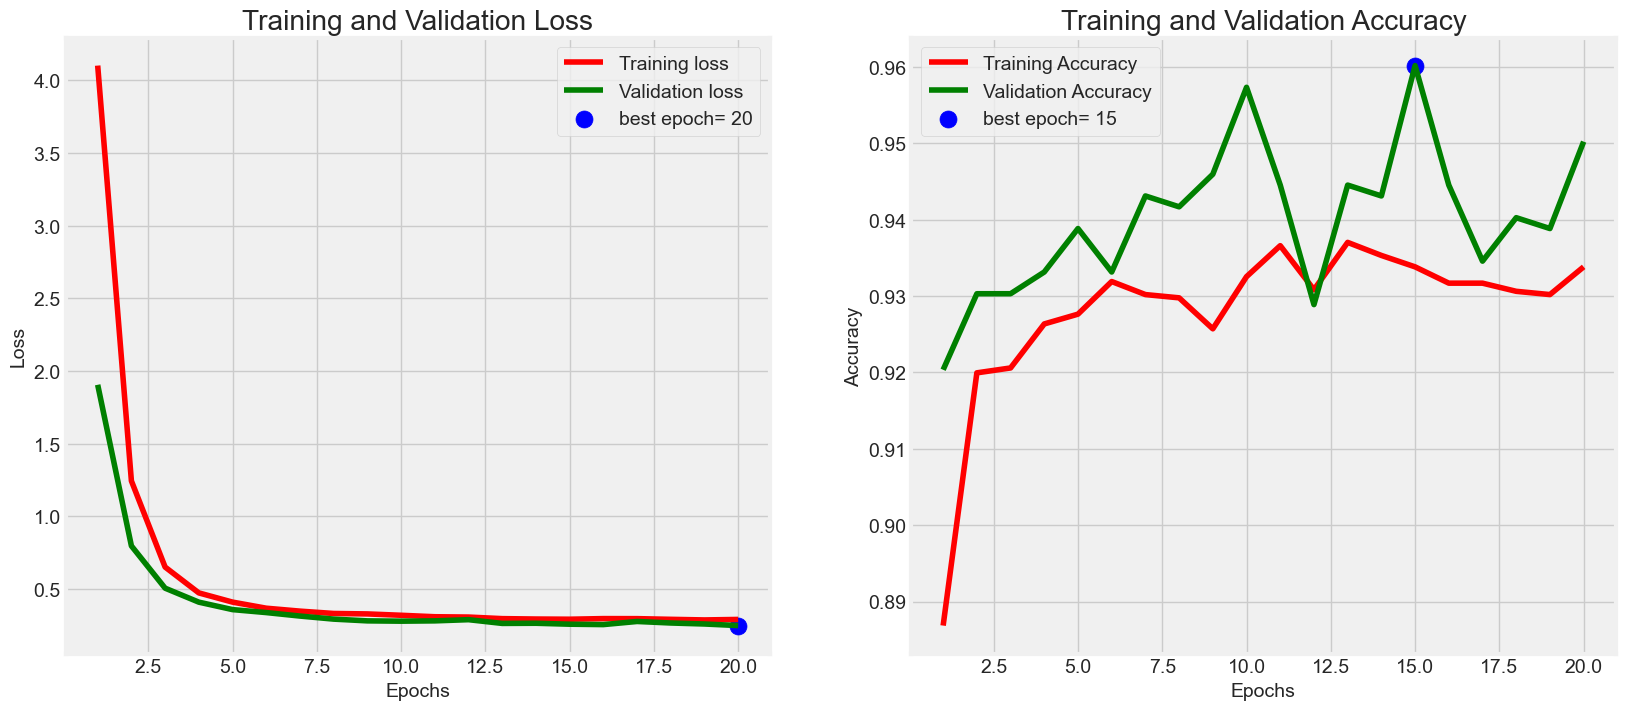

In [ ]:
# Define needed variables
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history

plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

In [ ]:
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

7/7 [==============================] - 16s 2s/step - loss: 0.2588 - accuracy: 0.9382
Train Loss:  0.22946496307849884
Train Accuracy:  0.9732142686843872
--------------------
Validation Loss:  0.2281368523836136
Validation Accuracy:  0.9464285969734192
--------------------
Test Loss:  0.258810430765152
Test Accuracy:  0.9381663203239441


In [44]:
preds = model.predict_generator(test_gen)
y_pred = np.argmax(preds, axis=1)

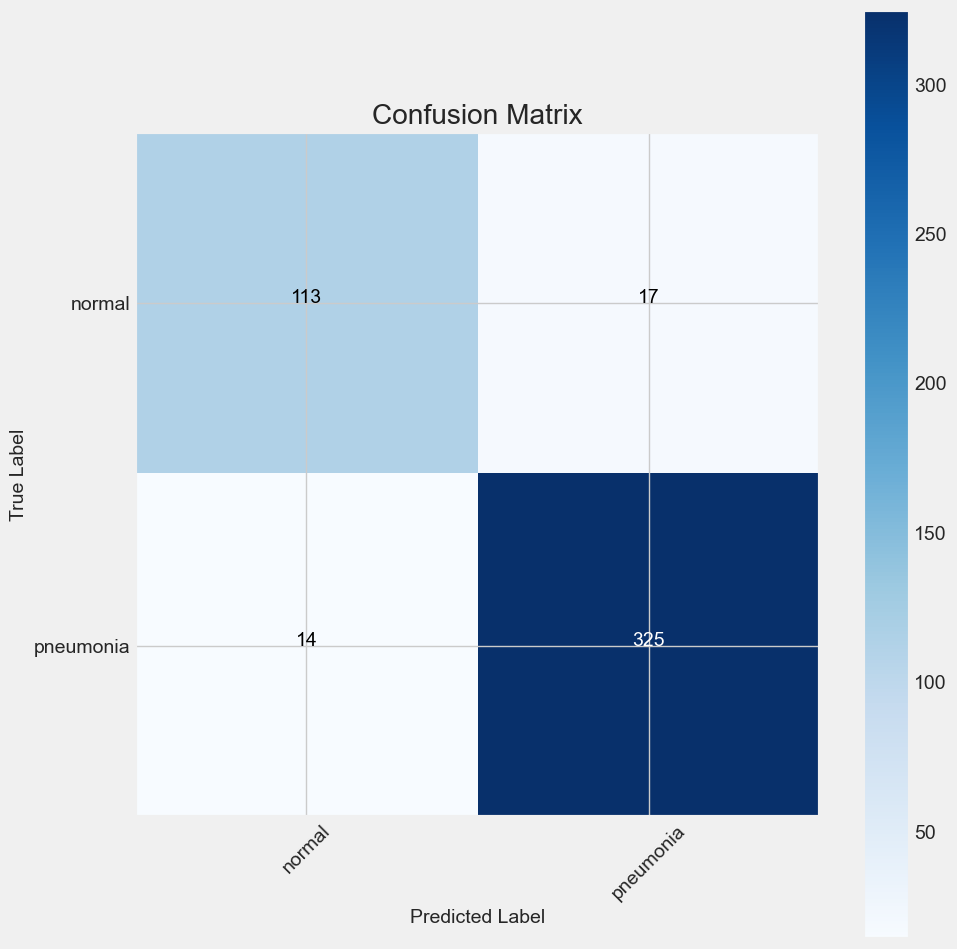

In [ ]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

In [46]:
# Classification report
print(classification_report(test_gen.classes, y_pred, target_names= classes))

              precision    recall  f1-score   support

      normal       0.91      0.91      0.91       130
   pneumonia       0.96      0.97      0.97       339

    accuracy                           0.95       469
   macro avg       0.94      0.94      0.94       469
weighted avg       0.95      0.95      0.95       469



In [ ]:
model.save_weights('my_model_weights.h5')

1/1 [==============================] - 1s 638ms/step


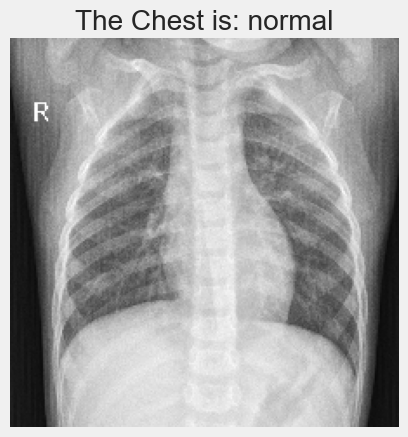

In [ ]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.efficientnet import preprocess_input

def predict_and_display(image_path, model, class_labels):
    
    img = image.load_img(image_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)

    prediction = model.predict(img_array)
    predicted_class_index = np.argmax(prediction)
    
    predicted_class_label = class_labels[predicted_class_index]
    
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"The Chest is: {predicted_class_label}")
    plt.show()

# Load your trained model
model.load_weights('my_model_weights.h5')

# Define your class labels (e.g., ['car', 'truck', ...])
class_labels = ['normal', 'pneumonia']

# Replace 'path_to_test_image' with the path to the image you want to test
image_path_to_test = 'dataset/data/normal/NORMAL2-IM-0897-0001.jpeg'
predict_and_display(image_path_to_test, model, class_labels)

1/1 [==============================] - 0s 69ms/step


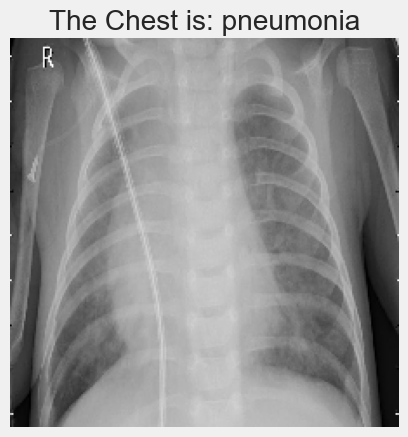

In [ ]:
image_path_to_test = 'dataset/data/pneumonia/person28_bacteria_141.jpeg'
predict_and_display(image_path_to_test, model, class_labels)

In [45]:
from sklearn.metrics import f1_score


# Calcul du F1-score
f1 = f1_score(test_gen.classes, y_pred)

# Affichage du F1-score
print("F1-score :", f1)

F1-score : 0.9661266568483063
